In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
from pathlib import Path

sys.path.append("..")

from dog import Dog
from featurebooster import FeatureBooster

orb_path = "../extractors/orbslam2_features/lib"
sys.path.append(str(orb_path))
from orbslam2_features import ORBextractor

superpoint_path = "../extractors/SuperPointPretrainedNetwork"
sys.path.append(str(superpoint_path))
from demo_superpoint import SuperPointFrontend

alike_path = "../extractors/ALIKE"
sys.path.append(str(alike_path))
import alike
from alike import ALike

import os
import cv2
import yaml
import numpy as np

import torch

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def normalize_keypoints(keypoints, image_shape):
    x0 = image_shape[1] / 2
    y0 = image_shape[0] / 2
    scale = max(image_shape) * 0.7
    kps = np.array(keypoints)
    kps[:, 0] = (keypoints[:, 0] - x0) / scale
    kps[:, 1] = (keypoints[:, 1] - y0) / scale
    return kps 

def draw_matches(image1, match_kp1, image2, match_kp2):
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    out_image = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
    out_image[:h1, :w1, :] = image1
    out_image[:h2, w1:w1+w2, :] = image2

    green = (0, 255, 0)
    blue = (0, 0, 255)
    yellow = (0, 255, 255)
    for (x1, y1), (x2, y2) in zip(match_kp1, match_kp2):
        cv2.circle(out_image, (int(x1), int(y1)), 6, yellow, -1)
        cv2.circle(out_image, (int(x2) + w1, int(y2)), 6, yellow, -1)
        cv2.line(out_image, (int(x1), int(y1)), (int(x2) + w1, int(y2)), green, 2)
    return out_image

In [3]:
desc_type = "ORB" # change the feature name here
pair_idx = 3
assert(pair_idx in [1, 2, 3])
pair_path = os.path.join('img%d' % pair_idx)
use_cuda = torch.cuda.is_available()

In [4]:
img1 = cv2.imread(os.path.join(pair_path, '1.jfif'))
img2 = cv2.imread(os.path.join(pair_path, '2.jfif'))

In [5]:
# set feature extractor
if desc_type.lower() in ['sift', 'rootsift', 'sosnet', 'hardnet']:
        feature_extractor = Dog(descriptor=desc_type.lower())
elif 'sift' in desc_type.lower():
    feature_extractor = Dog(descriptor='sift')
elif 'orb' in desc_type.lower():
    feature_extractor = ORBextractor(3000, 1.2, 8)
elif 'superpoint' in desc_type.lower():
    sp_weights_path = "../extractors/SuperPointPretrainedNetwork/superpoint_v1.pth"
    feature_extractor = SuperPointFrontend(weights_path=sp_weights_path, nms_dist=4, conf_thresh=0.015, nn_thresh=0.7, cuda=use_cuda)
elif 'alike' in desc_type.lower():
    feature_extractor = ALike(**alike.configs['alike-l'], device='cuda' if use_cuda else 'cpu', top_k=-1, scores_th=0.2)
else:
    raise Exception('Not supported descriptor: "%s".' % desc_type)

In [6]:
# set FeatureBooster
if "+Boost-" in desc_type:
    # load json config file
    config_file = "../config.yaml"
    with open(str(config_file), 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
    print(config[desc_type])

    # Model
    feature_booster = FeatureBooster(config[desc_type])
    if use_cuda:
        feature_booster.cuda()
    feature_booster.eval()
    # load the model
    model_path = str("../models/" + desc_type + ".pth")
    print(model_path)
    feature_booster.load_state_dict(torch.load(model_path))

In [7]:
def extract(image):
    if 'alike' in desc_type.lower():
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pred = feature_extractor(rgb, sub_pixel=True)
        keypoints = pred['keypoints']
        descriptors = pred['descriptors']
        scores = pred['scores']
        keypoints = np.hstack((keypoints, np.expand_dims(scores, 1)))
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if 'superpoint' in desc_type.lower():
            image = (image.astype('float32') / 255.)
            keypoints, descriptors, _ = feature_extractor.run(image)
            keypoints, descriptors = keypoints.T, descriptors.T
        elif desc_type.lower() in ['sift', 'rootsift', 'sosnet', 'hardnet']:
            image = (image.astype('float32') / 255.)
            keypoints, scores, descriptors = feature_extractor.detectAndCompute(image)
            keypoints = np.hstack((keypoints, np.expand_dims(scores, 1)))
        elif 'sift' in desc_type.lower():
            image = (image.astype('float32') / 255.)
            keypoints, scores, descriptors = feature_extractor.detectAndCompute(image)
        elif 'orb' in desc_type.lower():
            kps_tuples, descriptors = feature_extractor.detectAndCompute(image)
            # convert keypoints 
            keypoints = [cv2.KeyPoint(*kp) for kp in kps_tuples]
            keypoints = np.array(
                [[kp.pt[0], kp.pt[1], kp.size / 31, np.deg2rad(kp.angle)] for kp in keypoints], 
                dtype=np.float32
            )

    if "+Boost-" in desc_type:
        # boosted the descriptor using trained model
        kps = normalize_keypoints(keypoints, image.shape)
        kps = torch.from_numpy(kps.astype(np.float32))
        if 'orb' in desc_type.lower():
            descriptors = np.unpackbits(descriptors, axis=1, bitorder='little')
            descriptors = descriptors * 2.0 - 1.0
        descriptors = torch.from_numpy(descriptors.astype(np.float32))
        if use_cuda:
            kps = kps.cuda()
            descriptors = descriptors.cuda()
        out = feature_booster(descriptors, kps)
        if 'boost-b' in desc_type.lower():
            out = (out >= 0).cpu().detach().numpy()
            descriptors = np.packbits(out, axis=1, bitorder='little')
        else:
            descriptors = out.cpu().detach().numpy()

    # convert the keypoint to the form of cv2.KeyPoint
    keypoints = [cv2.KeyPoint(keypoints[i][0], keypoints[i][1], 2) for i in range(keypoints.shape[0])]

    return keypoints, descriptors

In [8]:
kps1, descs1 = extract(img1)
kps2, descs2 = extract(img2)

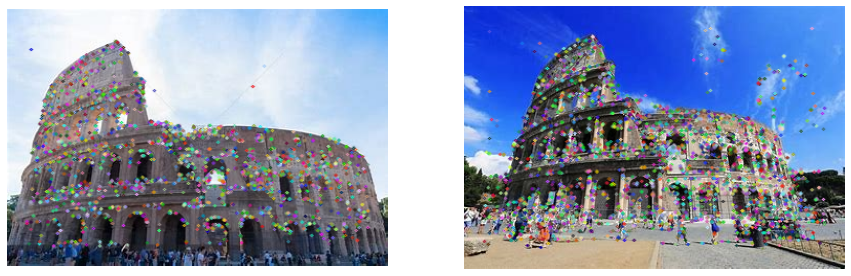

In [9]:
vis_img1 = cv2.drawKeypoints(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), kps1, None, 
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
vis_img2 = cv2.drawKeypoints(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), kps2, None, 
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1), plt.imshow(vis_img1), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(vis_img2), plt.axis('off')
plt.show()

In [10]:
# create BFMatcher object
bf_float = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
bf_binary = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

raw matches:  697
inliers:  8


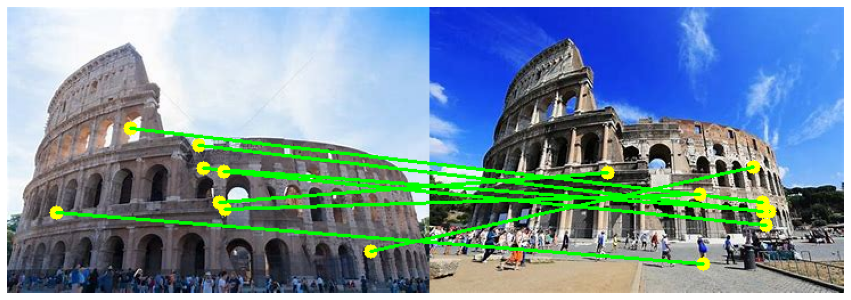

In [11]:
# Match descriptors.
if 'orb' in desc_type.lower() or '+Boost-B' in desc_type:
    matches = bf_binary.match(descs1, descs2)
else:
    matches = bf_float.match(descs1, descs2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
print('raw matches: ', len(matches))
src_pts = np.float32([ kps1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kps2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)

# RANSAC using Homography
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)
matchesMask = mask.ravel().tolist()
print('inliers: ', mask.sum())

# show the matches
matches = [ matches[i] for i in range(len(matches)) if matchesMask[i]]
src_pts = [ kps1[m.queryIdx].pt for m in matches ]
dst_pts = [ kps2[m.trainIdx].pt for m in matches ]
vis_img = draw_matches(img1, src_pts, img2, dst_pts)
vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.imshow(vis_img)
plt.axis('off')
plt.show()